In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
import boto3
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role

In [2]:
YOUR_NAME = 'yl-li'

In [3]:
sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'bankfraud-table7-08072019-houston' # Replace with your own bucket name if needed
print(bucket)
prefix = '{}/binary/ensemble'.format(YOUR_NAME) #Replace with the prefix under which you want to store the data if needed

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20190729T110615
bankfraud-table7-08072019-houston


In [5]:
#pwd

'/home/ec2-user/SageMaker'

In [30]:
#!wget https://www.kaggle.com/ntnu-testimon/paysim1

--2019-08-27 19:41:28--  https://www.kaggle.com/ntnu-testimon/paysim1
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘paysim1.1’

paysim1.1               [ <=>                ]  70.76K  --.-KB/s    in 0.01s   

2019-08-27 19:41:28 (5.33 MB/s) - ‘paysim1.1’ saved [72456]



In [4]:
data = pd.read_csv('s3://bankfraud-table7-08072019-houston/PS_20174392719_1491204439457_log.csv')

In [7]:
#data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.shape

(6362620, 11)

# Exploratory Analysis

col_0,% observations
type,
CASH_IN,0.219923
CASH_OUT,0.351663
DEBIT,0.006512
PAYMENT,0.338146
TRANSFER,0.083756


col_0,% observations
nameOrig,
C1000000639,1.571680e-07
C1000001337,1.571680e-07
C1000001725,1.571680e-07
C1000002591,1.571680e-07
C1000003372,1.571680e-07
C1000003615,1.571680e-07
C1000004053,1.571680e-07
C1000004530,1.571680e-07
C1000005353,1.571680e-07


col_0,% observations
nameDest,
C1000004082,9.430078e-07
C1000004940,2.043183e-06
C1000013769,2.043183e-06
C100001587,1.414512e-06
C1000015936,2.514687e-06
C1000022185,2.514687e-06
C1000026379,6.286718e-07
C1000030947,2.514687e-06
C100003532,1.571680e-07


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


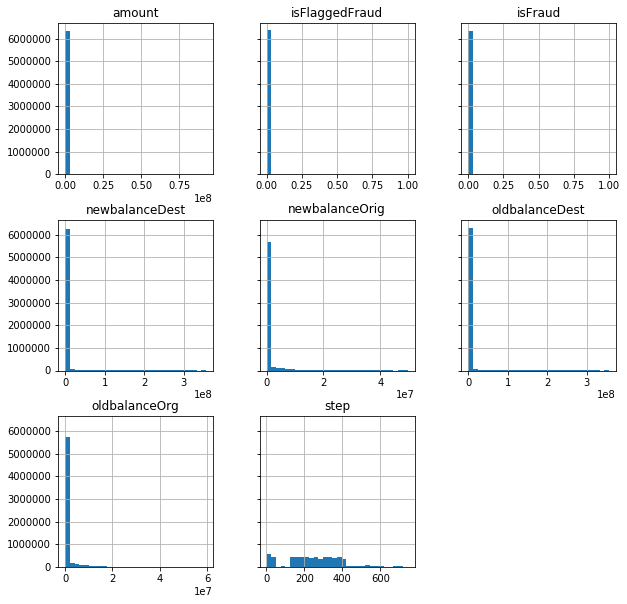

In [36]:
# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

In [47]:
#Drop some columns unuseful
data_reduced = data.drop(['nameOrig', 'nameDest'], axis=1)

In [21]:
#list(data_reduced.columns) 

['step',
 'type',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [22]:
#data_reduced.groupby('type').mean()[['isFraud']]

,isFraud
type,
CASH_IN,0.000000
CASH_OUT,0.001840
DEBIT,0.000000
PAYMENT,0.000000
TRANSFER,0.007688


In [23]:
#data_reduced.groupby('isFlaggedFraud').mean()[['isFraud']]

,isFraud
isFlaggedFraud,
0,0.001288
1,1.000000


In [48]:
data_reduced = data_reduced[(data_reduced.type=='CASH_OUT') | (data_reduced.type=='TRANSFER')]

In [49]:
data_reduced.shape

(2770409, 9)

In [50]:
data_reduced['hr_in_a_day'] = round(data_reduced['step']/24 - np.floor(data_reduced['step']/24),2)

In [51]:
data_reduced['Day_in_mnth'] = np.ceil(data_reduced['step']/24)

In [52]:
display(data_reduced.corr())

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hr_in_a_day,Day_in_mnth
step,1.000000,0.037007,0.005744,-0.011280,0.037778,0.037475,0.048671,0.005015,0.058253,0.999627
amount,0.037007,1.000000,0.120389,0.018296,0.307133,0.497027,0.070660,0.012301,-0.041545,0.038166
oldbalanceOrg,0.005744,0.120389,1.000000,0.778826,-0.020403,-0.010029,0.347582,0.074300,-0.025260,0.006463
newbalanceOrig,-0.011280,0.018296,0.778826,1.000000,-0.012277,-0.015439,0.063557,0.123957,-0.003975,-0.011133
oldbalanceDest,0.037778,0.307133,-0.020403,-0.012277,1.000000,0.970060,-0.014960,-0.000969,0.000678,0.037694
newbalanceDest,0.037475,0.497027,-0.010029,-0.015439,0.970060,1.000000,-0.008978,-0.001053,-0.008871,0.037670
isFraud,0.048671,0.070660,0.347582,0.063557,-0.014960,-0.008978,1.000000,0.044072,-0.051396,0.049906
isFlaggedFraud,0.005015,0.012301,0.074300,0.123957,-0.000969,-0.001053,0.044072,1.000000,-0.000737,0.005046
hr_in_a_day,0.058253,-0.041545,-0.025260,-0.003975,0.000678,-0.008871,-0.051396,-0.000737,1.000000,0.034296
Day_in_mnth,0.999627,0.038166,0.006463,-0.011133,0.037694,0.037670,0.049906,0.005046,0.034296,1.000000


In [53]:
data_reduced.groupby('hr_in_a_day').mean()[['isFraud']]

,isFraud
hr_in_a_day,
0.00,0.016471
0.04,0.059617
0.08,0.193548
0.12,0.417949
0.17,0.535156
0.21,0.579114
0.25,0.396018
0.29,0.129032
0.33,0.035721


In [54]:
data_reduced.groupby('Day_in_mnth').mean()[['isFraud']]

,isFraud
Day_in_mnth,
1.0,0.001079
2.0,0.001523
3.0,0.722611
4.0,0.029888
5.0,0.094206
6.0,0.001164
7.0,0.001462
8.0,0.001411
9.0,0.001404


In [55]:
##Create Dummies
data_reduced = pd.get_dummies(data_reduced, columns=['type','hr_in_a_day', 'Day_in_mnth'], dummy_na=True)

In [56]:
list(data_reduced)

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'type_CASH_OUT',
 'type_TRANSFER',
 'type_nan',
 'hr_in_a_day_0.0',
 'hr_in_a_day_0.04',
 'hr_in_a_day_0.08',
 'hr_in_a_day_0.12',
 'hr_in_a_day_0.17',
 'hr_in_a_day_0.21',
 'hr_in_a_day_0.25',
 'hr_in_a_day_0.29',
 'hr_in_a_day_0.33',
 'hr_in_a_day_0.38',
 'hr_in_a_day_0.42',
 'hr_in_a_day_0.46',
 'hr_in_a_day_0.5',
 'hr_in_a_day_0.54',
 'hr_in_a_day_0.58',
 'hr_in_a_day_0.62',
 'hr_in_a_day_0.67',
 'hr_in_a_day_0.71',
 'hr_in_a_day_0.75',
 'hr_in_a_day_0.79',
 'hr_in_a_day_0.83',
 'hr_in_a_day_0.88',
 'hr_in_a_day_0.92',
 'hr_in_a_day_0.96',
 'hr_in_a_day_nan',
 'Day_in_mnth_1.0',
 'Day_in_mnth_2.0',
 'Day_in_mnth_3.0',
 'Day_in_mnth_4.0',
 'Day_in_mnth_5.0',
 'Day_in_mnth_6.0',
 'Day_in_mnth_7.0',
 'Day_in_mnth_8.0',
 'Day_in_mnth_9.0',
 'Day_in_mnth_10.0',
 'Day_in_mnth_11.0',
 'Day_in_mnth_12.0',
 'Day_in_mnth_13.0',
 'Day_in_mnth_14.0',
 'Day_in_mnth_15.0